## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Connect to Database and Extract Data

In [2]:
# Check if database exists and has data
import os

# Flask stores database in instance folder by default
db_path = 'instance/refit_energy_data.db'

if not os.path.exists(db_path):
    print(f"✗ Database '{db_path}' not found!")
    print("\nPlease run the Flask app first to create and populate the database:")
    print("  1. Open a terminal")
    print("  2. cd backend")
    print("  3. .\\venv\\Scripts\\Activate.ps1")
    print("  4. python app.py")
    print("\nThis will load the energy_data.csv into the database.")
    print("After that, you can return to this notebook and run the remaining cells.")
else:
    print(f"✓ Database '{db_path}' found!")
    
    # Check if it has data
    from sqlalchemy import inspect
    temp_engine = create_engine(f'sqlite:///{db_path}')
    
    try:
        inspector = inspect(temp_engine)
        
        if 'energy_readings' in inspector.get_table_names():
            # Count total records and check available households
            query_count = "SELECT COUNT(*) as count FROM energy_readings"
            count_df = pd.read_sql_query(query_count, temp_engine)
            total_count = count_df['count'].iloc[0]
            
            # Get unique household IDs
            query_households = "SELECT DISTINCT household_id FROM energy_readings"
            households_df = pd.read_sql_query(query_households, temp_engine)
            households = households_df['household_id'].tolist()
            
            print(f"✓ Table 'energy_readings' exists with {total_count} total records")
            print(f"✓ Available households: {households}")
            
            if total_count == 0:
                print("\n⚠ Warning: No data found. Run Flask app to load data.")
            else:
                print(f"✓ Ready to proceed with model training!")
        else:
            print("\n✗ Table 'energy_readings' not found in database!")
            print("Make sure Flask app has fully started and loaded the data.")
    except Exception as e:
        print(f"\n✗ Error: {e}")
        print("Please ensure Flask app is running and has completed initialization.")

✓ Database 'instance/refit_energy_data.db' found!
✓ Table 'energy_readings' exists with 921 total records
✓ Available households: [1, 2, 3, 4, 5]
✓ Ready to proceed with model training!


## 3. Query Data from Database

In [3]:
# Load data directly from CSV file (more reliable than database)
# Using energy_categorical.csv which includes target categories
csv_path = '../energy_categorical.csv'

df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter for household 1
df = df[df['household_id'] == 1].copy()

print(f"Loaded {len(df)} records for household 1")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Energy consumption range: {df['energy_consumption_kWh'].min():.4f} to {df['energy_consumption_kWh'].max():.4f} kWh")
print(f"\nTarget categories distribution:")
print(df['target_category'].value_counts())
print(f"\nFirst few records:")
df.head(10)

Loaded 184 records for household 1
Date range: 2024-01-01 00:00:00 to 2024-01-01 15:15:00
Energy consumption range: 0.0593 to 0.3312 kWh

Target categories distribution:
target_category
Medium    65
High      61
Low       58
Name: count, dtype: int64

First few records:


,timestamp,household_id,energy_consumption_kWh,future_consumption_kWh,target_category
0,2024-01-01 00:00:00,1,0.208750,0.238588,Medium
1,2024-01-01 00:05:00,1,0.238588,0.256830,High
2,2024-01-01 00:10:00,1,0.256830,0.206643,Medium
3,2024-01-01 00:15:00,1,0.206643,0.243535,Medium
4,2024-01-01 00:20:00,1,0.243535,0.242188,Medium
5,2024-01-01 00:25:00,1,0.242188,0.283924,High
6,2024-01-01 00:30:00,1,0.283924,0.240034,Medium
7,2024-01-01 00:35:00,1,0.240034,0.248543,Medium
8,2024-01-01 00:40:00,1,0.248543,0.310033,High
9,2024-01-01 00:45:00,1,0.310033,0.314712,High


## 4. Feature Engineering

In [4]:
# Enhanced Feature Engineering
# 1. Time-based features
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# 2. Lagged features (previous consumption values)
df['lag_1'] = df['energy_consumption_kWh'].shift(1)  # Previous reading
df['lag_2'] = df['energy_consumption_kWh'].shift(2)  # 2 readings ago
df['lag_3'] = df['energy_consumption_kWh'].shift(3)  # 3 readings ago

# 3. Rolling statistics (moving averages)
df['rolling_mean_3'] = df['energy_consumption_kWh'].rolling(window=3, min_periods=1).mean()
df['rolling_mean_6'] = df['energy_consumption_kWh'].rolling(window=6, min_periods=1).mean()
df['rolling_std_3'] = df['energy_consumption_kWh'].rolling(window=3, min_periods=1).std().fillna(0)

# 4. Time of day categories
def time_category(hour):
    if 0 <= hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

df['time_category'] = df['hour_of_day'].apply(time_category)

# Drop rows with NaN values created by lagging
df = df.dropna()

print("Enhanced Feature Engineering Complete!")
print(f"\nDataset shape after feature engineering: {df.shape}")
print(f"\nFeature Statistics:")
feature_cols = ['hour_of_day', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 
                'rolling_mean_3', 'rolling_std_3', 'time_category', 'energy_consumption_kWh']
print(df[feature_cols].describe())

print(f"\nData diversity check:")
print(f"  Unique hours: {df['hour_of_day'].nunique()}")
print(f"  Unique days: {df['day_of_year'].nunique()}")
print(f"  Records: {len(df)}")

df.head(10)

Enhanced Feature Engineering Complete!

Dataset shape after feature engineering: (181, 17)

Feature Statistics:
       hour_of_day  is_weekend       lag_1       lag_2       lag_3  \
count   181.000000       181.0  181.000000  181.000000  181.000000   
mean      7.292818         0.0    0.200473    0.200953    0.201182   
std       4.380183         0.0    0.074235    0.074199    0.074158   
min       0.000000         0.0    0.059322    0.059322    0.059322   
25%       4.000000         0.0    0.138838    0.138838    0.138838   
50%       7.000000         0.0    0.191193    0.191880    0.194027   
75%      11.000000         0.0    0.273173    0.273173    0.273173   
max      15.000000         0.0    0.331167    0.331167    0.331167   

       rolling_mean_3  rolling_std_3  time_category  energy_consumption_kWh  
count      181.000000     181.000000     181.000000              181.000000  
mean         0.200444       0.019069       0.839779                0.199906  
std          0.072113  

,timestamp,household_id,energy_consumption_kWh,future_consumption_kWh,target_category,hour_of_day,day_of_week,day_of_year,month,is_weekend,lag_1,lag_2,lag_3,rolling_mean_3,rolling_mean_6,rolling_std_3,time_category
3,2024-01-01 00:15:00,1,0.206643,0.243535,Medium,0,0,1,1,0,0.256830,0.238588,0.208750,0.234020,0.227703,0.025403,0
4,2024-01-01 00:20:00,1,0.243535,0.242188,Medium,0,0,1,1,0,0.206643,0.256830,0.238588,0.235669,0.230869,0.026002,0
5,2024-01-01 00:25:00,1,0.242188,0.283924,High,0,0,1,1,0,0.243535,0.206643,0.256830,0.230788,0.232755,0.020922,0
6,2024-01-01 00:30:00,1,0.283924,0.240034,Medium,0,0,1,1,0,0.242188,0.243535,0.206643,0.256549,0.245284,0.023717,0
7,2024-01-01 00:35:00,1,0.240034,0.248543,Medium,0,0,1,1,0,0.283924,0.242188,0.243535,0.255382,0.245525,0.024742,0
8,2024-01-01 00:40:00,1,0.248543,0.310033,High,0,0,1,1,0,0.240034,0.283924,0.242188,0.257500,0.244144,0.023276,0
9,2024-01-01 00:45:00,1,0.310033,0.314712,High,0,0,1,1,0,0.248543,0.240034,0.283924,0.266203,0.261376,0.038195,0
10,2024-01-01 00:50:00,1,0.314712,0.271510,High,0,0,1,1,0,0.310033,0.248543,0.240034,0.291096,0.273239,0.036926,0
11,2024-01-01 00:55:00,1,0.271510,0.287534,High,0,0,1,1,0,0.314712,0.310033,0.248543,0.298752,0.278126,0.023708,0
12,2024-01-01 01:00:00,1,0.287534,0.316991,High,1,0,1,1,0,0.271510,0.314712,0.310033,0.291252,0.278728,0.021840,0


## 5. Prepare Training and Testing Data

In [5]:
# Define enhanced features and target
# Using lagged values and rolling statistics which are strong predictors
feature_columns = [
    'hour_of_day', 'day_of_week', 'is_weekend', 'time_category',
    'lag_1', 'lag_2', 'lag_3',  # Previous consumption values
    'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3'  # Moving statistics
]

X = df[feature_columns]
y = df['future_consumption_kWh']  # Predict FUTURE consumption, not current!

# Split data: 80% training, 20% testing (standard split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Don't shuffle to maintain time order
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nFeatures used ({len(feature_columns)}):")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")
print(f"\nTarget variable: future_consumption_kWh (NOT current consumption!)")
print(f"\nThis ensures we're predicting the NEXT time period's consumption,")
print(f"not just memorizing the current consumption via lagged features.")

Training samples: 144
Testing samples: 37

Features used (10):
  1. hour_of_day
  2. day_of_week
  3. is_weekend
  4. time_category
  5. lag_1
  6. lag_2
  7. lag_3
  8. rolling_mean_3
  9. rolling_mean_6
  10. rolling_std_3

Target variable: future_consumption_kWh (NOT current consumption!)

This ensures we're predicting the NEXT time period's consumption,
not just memorizing the current consumption via lagged features.


## 6. Train the Prediction Model

In [6]:
# Initialize and train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained successfully!")
print(f"\nModel Coefficients:")
for feature, coef in zip(feature_columns, model.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"  Intercept: {model.intercept_:.4f}")

Model trained successfully!

Model Coefficients:
  hour_of_day: 0.0021
  day_of_week: 0.0000
  is_weekend: 0.0000
  time_category: -0.0133
  lag_1: -0.1067
  lag_2: -0.3361
  lag_3: 0.1575
  rolling_mean_3: 1.6896
  rolling_mean_6: -0.4407
  rolling_std_3: 0.1975
  Intercept: -0.0003


## 7. Evaluate Model Performance

In [7]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"  Mean Absolute Error (MAE): {mae:.4f} kWh")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f} kWh")
print(f"  R² Score: {r2:.4f}")

# Interpret R² score
if r2 >= 0.7:
    interpretation = "Excellent - model explains most variance"
elif r2 >= 0.5:
    interpretation = "Good - model captures major patterns"
elif r2 >= 0.3:
    interpretation = "Moderate - some predictive power"
elif r2 >= 0:
    interpretation = "Poor - barely better than mean baseline"
else:
    interpretation = "Very Poor - worse than predicting mean"

print(f"  Interpretation: {interpretation}")
print(f"\nAverage actual future consumption: {y_test.mean():.4f} kWh")
print(f"Average predicted future consumption: {y_pred.mean():.4f} kWh")
print(f"\nNote: MAE of {mae:.4f} kWh means predictions are off by ~{mae*1000:.1f} Wh on average.")

Model Performance Metrics:
  Mean Absolute Error (MAE): 0.0217 kWh
  Root Mean Squared Error (RMSE): 0.0264 kWh
  R² Score: 0.7425
  Interpretation: Excellent - model explains most variance

Average actual future consumption: 0.1524 kWh
Average predicted future consumption: 0.1542 kWh

Note: MAE of 0.0217 kWh means predictions are off by ~21.7 Wh on average.


## 8. Visualize Predictions

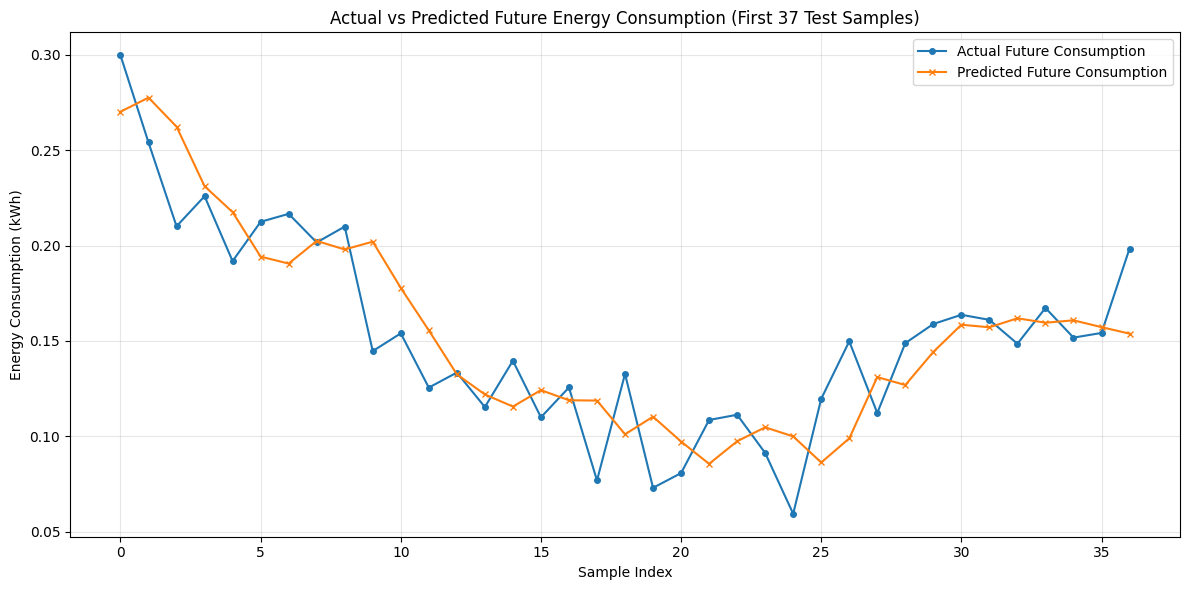

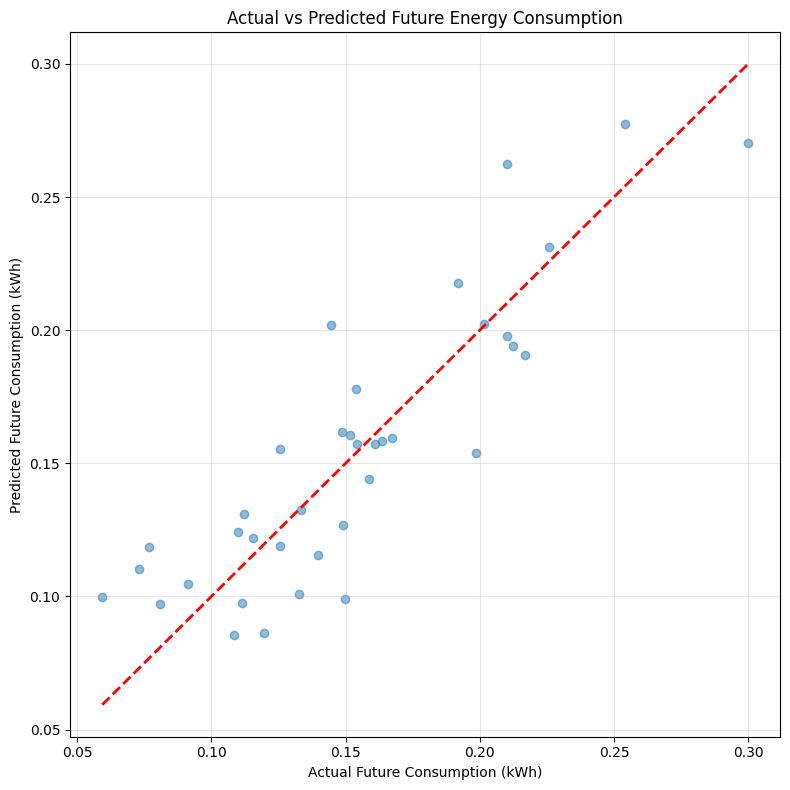

In [8]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plot_samples = min(100, len(y_test))
plt.plot(y_test.values[:plot_samples], label='Actual Future Consumption', marker='o', markersize=4)
plt.plot(y_pred[:plot_samples], label='Predicted Future Consumption', marker='x', markersize=4)
plt.xlabel('Sample Index')
plt.ylabel('Energy Consumption (kWh)')
plt.title(f'Actual vs Predicted Future Energy Consumption (First {plot_samples} Test Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Future Consumption (kWh)')
plt.ylabel('Predicted Future Consumption (kWh)')
plt.title('Actual vs Predicted Future Energy Consumption')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save the Trained Model

In [9]:
# Serialize the model using joblib
model_filename = 'energy_predictor_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved successfully to '{model_filename}'!")
print(f"\nModel details:")
print(f"  Type: {type(model).__name__}")
print(f"  Features: {feature_columns}")
print(f"  Training samples: {len(X_train)}")
print(f"  MAE: {mae:.2f} W")
print(f"  R² Score: {r2:.4f}")

Model saved successfully to 'energy_predictor_model.joblib'!

Model details:
  Type: LinearRegression
  Features: ['hour_of_day', 'day_of_week', 'is_weekend', 'time_category', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3']
  Training samples: 144
  MAE: 0.02 W
  R² Score: 0.7425


## 10. Test Model Loading (Verification)

In [10]:
# Load the saved model and verify it works
loaded_model = joblib.load(model_filename)

# Make a test prediction
test_sample = X_test.iloc[:1]
prediction = loaded_model.predict(test_sample)

print("Model loading test successful!")
print(f"\nTest input features:")
print(test_sample)
print(f"\nPredicted future consumption: {prediction[0]:.4f} kWh")
print(f"Actual future consumption: {y_test.iloc[0]:.4f} kWh")
print(f"Prediction error: {abs(prediction[0] - y_test.iloc[0]):.4f} kWh ({abs(prediction[0] - y_test.iloc[0])*1000:.1f} Wh)")
print(f"\nThe model is ready for deployment in Flask API!")

Model loading test successful!

Test input features:
     hour_of_day  day_of_week  is_weekend  time_category     lag_1     lag_2  \
147           12            0           0              2  0.285034  0.313301   

        lag_3  rolling_mean_3  rolling_mean_6  rolling_std_3  
147  0.283809         0.28667        0.286252       0.025852  

Predicted future consumption: 0.2702 kWh
Actual future consumption: 0.2999 kWh
Prediction error: 0.0296 kWh (29.6 Wh)

The model is ready for deployment in Flask API!
